From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from methods import *

# Choice of Model to Attack
- LeNet5: MNIST
- Basic CNN: Fashion MNIST
- ResNet20: CIFAR-10
### Run **ONE** of the following 3 cells

In [2]:
from models.LeNet import *
target_mdl = LeNet("models/lenet_mnist_model.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

In [3]:
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Running on cpu.
Model weights loaded successfully


In [2]:
from models.resNet import ResNet20
target_mdl = ResNet20()
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Using cache found in C:\Users\JIC/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [3]:
accuracies = []
examples = []
hist_dfs = []
final_hist_dfs = []
fw_iters = [15]
eps = 0.005
adv_examples = []
hist = None
debug = True
# Run test for each epsilon
algs = ['fw_pair']
for alg in algs:
    acc, ex, hist = test_fw(target_mdl, device, eps, 15, method=alg, early_stopping='gap_FW', fw_stepsize_rule='decay', gap_FW_tol=0.1)
    accuracies.append(acc)
    examples.append(ex)
    hist_dfs.append(hist)
    final_hist = hist.groupby('example_idx').tail(1)
    final_hist_dfs.append(final_hist) # hist with just the rows of last FW iters
final_hist_dfs[-1]

Epsilon: 0.005	Correct Classifications (Failed Attacks) = 21 / 1000 = 0.021


example_idx  FW_iter        gap_FW  success  first_success  target  \
1               0        2  4.201375e-05     True          False       3   
3               1        2  8.486261e-07     True          False       8   
6               2        3  4.670081e-06     True          False       8   
8               3        2  4.230366e-03     True          False       3   
12              4        4  4.908016e-03     True          False       1   
...           ...      ...           ...      ...            ...     ...   
2779          995        2  9.880333e-03     True          False       3   
2782          996        3  4.008762e-02     True          False       7   
2784          997        2  9.930397e-05     True          False       4   
2786          998        2  5.892874e-03     True          False       1   
2788          999        2  3.476207e-04     True          False       4   

      pred stop_cond        gap_AS  
1        5       gap  7.503471e-06  
3        9       gap  3.965401e-07  
6        0       gap  2.393796e-06  
8        5       gap  1.692674e-03  
12       9       gap  1.398546e-02  
...    ...       ...           ...  
2779     5       gap  6.127258e-03  
2782     2       gap  2.065122e-01  
2784     3       gap  4.763584e-06  
2786     0       gap -9.731574e-11  
2788     6       gap  1.265310e-05  

[927 rows x 9 columns]

In [4]:
hist

example_idx  FW_iter     gap_FW  success  first_success  target  pred  \
0              0        1  -2.837338     True           True       3     5   
1              1        1  -5.535796     True           True       8     9   
2              2        1  -4.455529     True           True       8     0   
3              3        1  -1.842142     True           True       3     5   
4              4        1  -2.068491    False          False       1     1   
..           ...      ...        ...      ...            ...     ...   ...   
922          995        1  -4.152540     True           True       3     5   
923          996        1  -3.782328    False          False       7     7   
924          997        1 -10.961019     True           True       4     3   
925          998        1  -4.556056     True           True       1     0   
926          999        1 -10.682369     True           True       4     6   

    stop_cond  gap_AS  
0         gap     0.0  
1         gap     0.0  
2         gap     0.0  
3         gap     0.0  
4         gap     0.0  
..        ...     ...  
922       gap     0.0  
923       gap     0.0  
924       gap     0.0  
925       gap     0.0  
926       gap     0.0  

[927 rows x 9 columns]

In [7]:
hist.groupby('step_type').size()

step_type
AS     245
FW    3885
dtype: int64

<Axes: xlabel='FW_iter'>

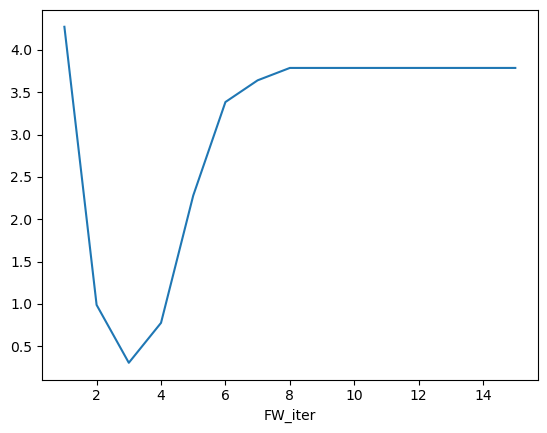

In [4]:
hist.groupby('FW_iter')['gap_FW'].mean().plot()

In [5]:
final_hist.groupby('stop_cond').size()

stop_cond
gap         902
max_iter     25
dtype: int64

In [11]:
final_hist.groupby('success')['gap_FW'].mean()

success
False    0.311612
True     0.031802
Name: gap_FW, dtype: float64

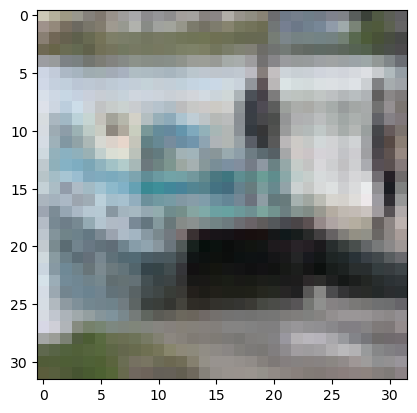

In [ ]:
plt.imshow(np.transpose(ex[3][2], (1, 2, 0)))

Mean FW iterations: 3.0086299892125137


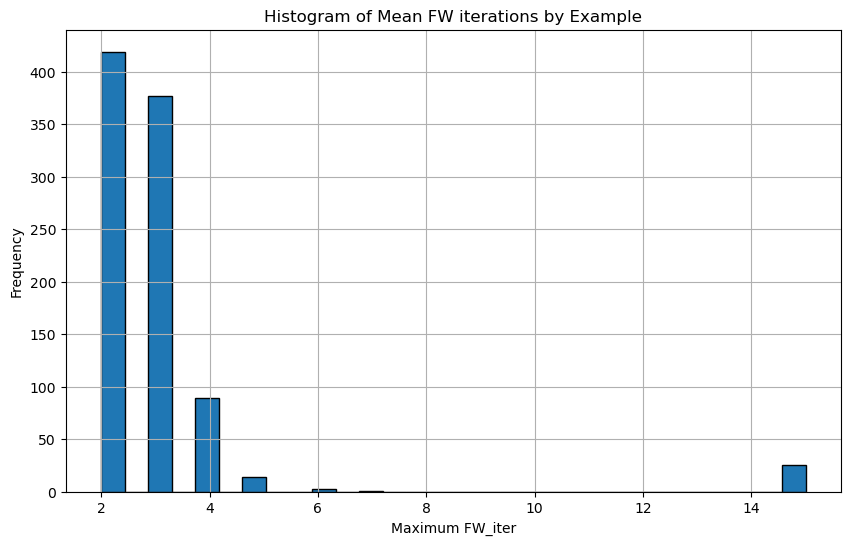

In [8]:
num_iters = hist.groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Mean FW iterations by Example')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.7784946236559139

In [ ]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

1.4820441988950277

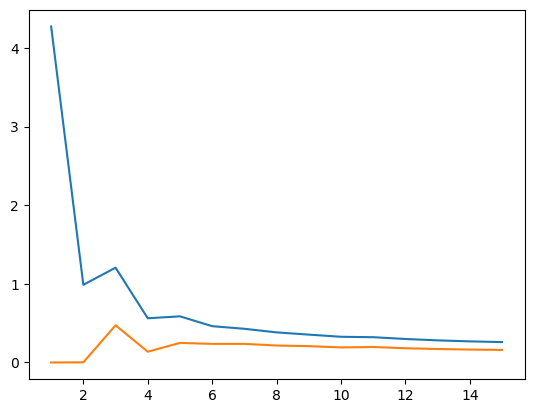

In [7]:
plt.plot(hist.groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist.groupby('FW_iter')['gap_AS'].mean())

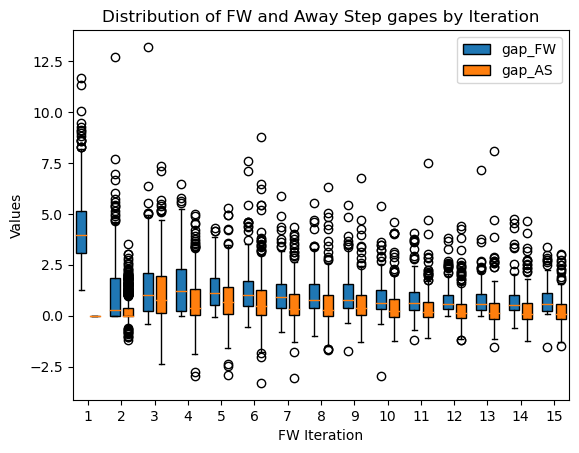

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data generation for demonstration purposes

# Extracting unique iteration groups
groups = hist['FW_iter'].unique()

# Creating lists to hold data for each group
data_FW = []
data_AS = []

for group in groups:
    data_FW.append(hist[hist['FW_iter'] == group]['gap_FW'].values)
    data_AS.append(hist[hist['FW_iter'] == group]['gap_AS'].values)

# Plotting
fig, ax = plt.subplots()

# Positions of the boxplots
positions_FW = np.arange(1, len(groups) + 1) * 2.0 - 0.4
positions_AS = np.arange(1, len(groups) + 1) * 2.0 + 0.4

# Creating the boxplots
box_FW = ax.boxplot(data_FW, positions=positions_FW, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C0"))
box_AS = ax.boxplot(data_AS, positions=positions_AS, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C1"))

# Customizing the plot
ax.set_xlabel('FW Iteration')
ax.set_ylabel('Values')
ax.set_title('Distribution of FW and Away Step gapes by Iteration')
ax.set_xticks(np.arange(1, len(groups) + 1) * 2.0)
ax.set_xticklabels([i for i in groups])

# Adding legend
ax.legend([box_FW["boxes"][0], box_AS["boxes"][0]], ['gap_FW', 'gap_AS'], loc='upper right')

# Display the plot
plt.show()


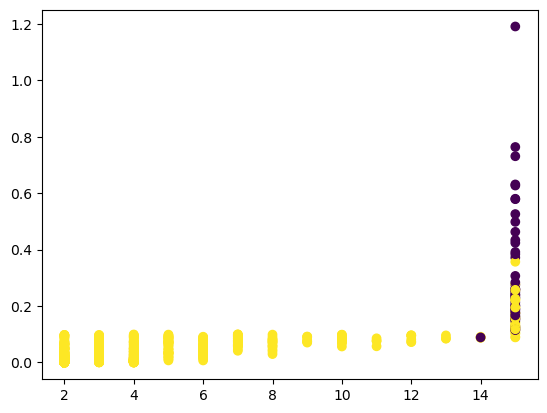

In [15]:
plt.scatter(final_hist['FW_iter'],final_hist['gap_FW'], c=final_hist['success'])

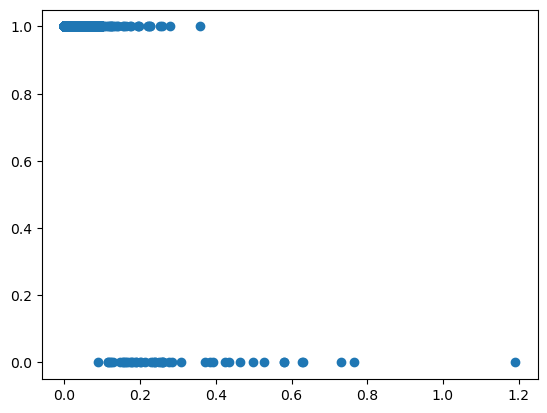

In [16]:
plt.scatter(final_hist['gap_FW'], final_hist['success'])

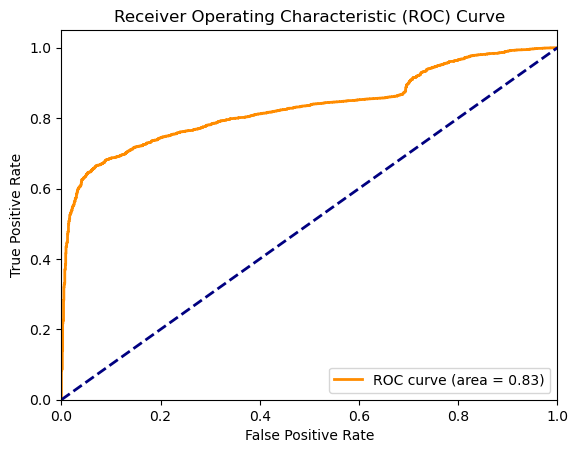

In [ ]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

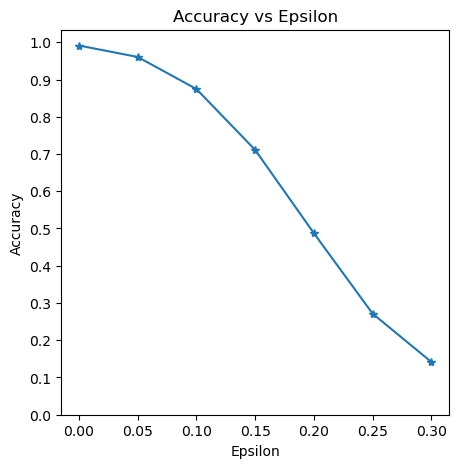

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

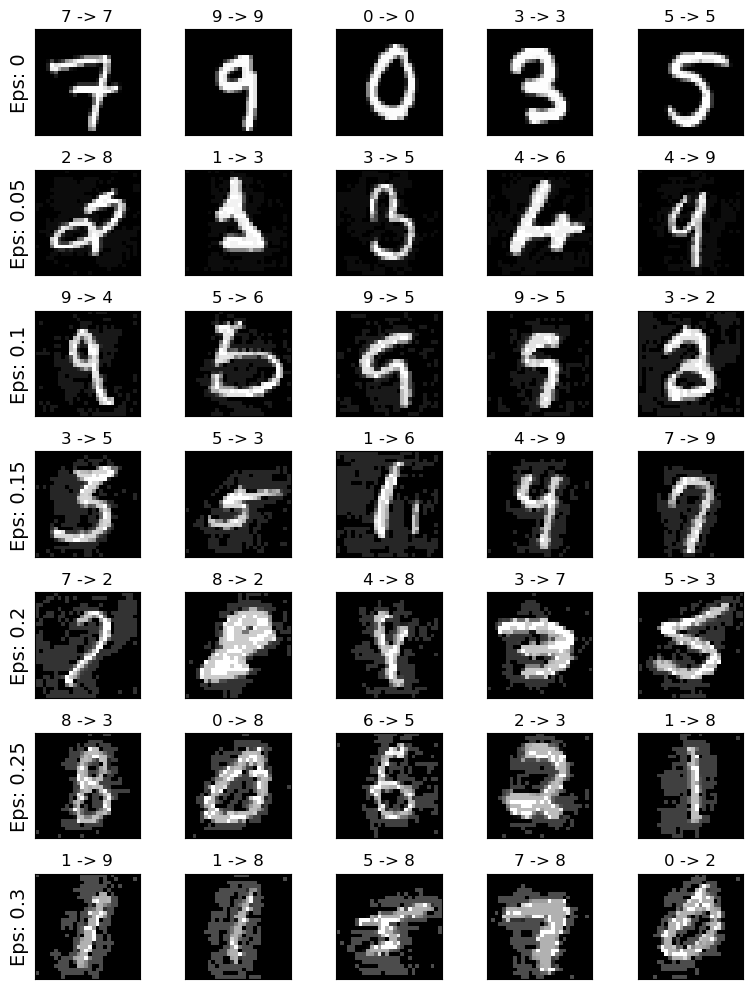

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()